In [1]:
import scanpy as sc
import anndata as ad
import muon as mu
import mudata as md
import numpy as np
import pandas as pd
import os
import warnings
import scipy
import celltypist
import random

In [2]:
mu.set_options(pull_on_update = False)

## Initial Processing and QC  
#### This section includes everything from loading in the data and QC all the way to generating umaps and identifying cell types

CONFIGURATION  
Users: Update the DATA_DIR path to point to where you downloaded the GEO .h5 files

In [3]:
DATA_DIR = '/fs/scratch/PAS2527/GEO_Submission/'  # or '/path/to/your/files'

# Helper function to load files cleanly
def load_h5(filename):
    file_path = os.path.join(DATA_DIR, filename)
    if not os.path.exists(file_path):
        print(f"Warning: File not found: {file_path}")
        return None
    
    # Load the data
    # Silence the warning during the read
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning, module="(anndata|mudata)")
        mdata = mu.read_10x_h5(file_path)
    
    # THE FIX: This forces unique names immediately
    # (e.g., if 'GeneA' appears twice, it becomes 'GeneA' and 'GeneA-1')
    mdata.var_names_make_unique()
    
    return mdata


# Helper function to run DSB on a specific sample
def apply_dsb(sample_name, mdata, prefix="D14"):
    # ... (Filename construction logic) ...
    
    file_suffix = sample_name.replace("-", "") 
    raw_filename = f"{prefix}_{file_suffix}_raw_feature_bc_matrix.h5"
    raw_path = os.path.join(DATA_DIR, raw_filename)
    
    if not os.path.exists(raw_path):
        print(f"Skipping DSB for {sample_name}: Raw file not found")
        return

    print(f"Running DSB on {sample_name}...")
    
    # Load Raw Object silently
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        mdata_raw = mu.read_10x_h5(raw_path)

    # RUN DSB (With warning suppression)
    with warnings.catch_warnings():
        # Silence the specific "empty_counts_range" warning
        warnings.filterwarnings("ignore", message="empty_counts_range values are not provided")
        mu.prot.pp.dsb(mdata, data_raw=mdata_raw)

# Function to safely copy columns from RNA to Global
def copy_obs_to_global(mdata, cols):
    for col in cols:
        if col in mdata.mod['rna'].obs.columns:
            # We copy it to the global .obs with a prefix so we know it came from RNA
            # (e.g. 'rna:pct_counts_mt')
            mdata.obs[col] = mdata.mod['rna'].obs[col].copy()


#Funciton to filter out outliers using median absolute deviation
def is_outlier(adata, metric: str, n_mads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - n_mads * scipy.stats.median_abs_deviation(M)) | (
        np.median(M) + n_mads * scipy.stats.median_abs_deviation(M) < M
    )
    return outlier

In [4]:
# Day 14 Data Loading
day_14_data = {
    'MRAC103_15-D': load_h5('D14_MRAC103_15D_filtered_feature_bc_matrix.h5'),
    'MRAC103_15-C': load_h5('D14_MRAC103_15C_filtered_feature_bc_matrix.h5'),
    'MRAC104_15-D': load_h5('D14_MRAC104_15D_filtered_feature_bc_matrix.h5'),
    'MRAC104_15-C': load_h5('D14_MRAC104_15C_filtered_feature_bc_matrix.h5')
}

# Day 28 Data Loading
day_28_data = {
    'MRAC103_15-D': load_h5('D28_MRAC103_15D_filtered_feature_bc_matrix.h5'),
    'MRAC103_15-C': load_h5('D28_MRAC103_15C_filtered_feature_bc_matrix.h5'),
    'MRAC104_15-D': load_h5('D28_MRAC104_15D_filtered_feature_bc_matrix.h5'),
    'MRAC104_15-C': load_h5('D28_MRAC104_15C_filtered_feature_bc_matrix.h5')
}

In [5]:
# ==========================================
# 1. Normalize Day 14 Samples (Individually)
# ==========================================
print("--- Normalizing Day 14 ---")
for name, mdata in day_14_data.items():
    apply_dsb(name, mdata, prefix="D14")

# ==========================================
# 2. Normalize Day 28 Samples (Individually)
# ==========================================
print("\n--- Normalizing Day 28 ---")
for name, mdata in day_28_data.items():
    apply_dsb(name, mdata, prefix="D28")

# ==========================================
# 3. NOW Concatenate them
# ==========================================
print("\n--- Concatenating ---")
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    day_14_data_combined = md.concat(day_14_data, merge='same', index_unique="_")
    day_28_data_combined = md.concat(day_28_data, merge='same', index_unique="_")

print("Done! DSB layers are preserved in the combined objects.")

--- Normalizing Day 14 ---
Running DSB on MRAC103_15-D...
Running DSB on MRAC103_15-C...
Running DSB on MRAC104_15-D...
Running DSB on MRAC104_15-C...

--- Normalizing Day 28 ---
Running DSB on MRAC103_15-D...
Running DSB on MRAC103_15-C...
Running DSB on MRAC104_15-D...
Running DSB on MRAC104_15-C...

--- Concatenating ---
Done! DSB layers are preserved in the combined objects.


Create a merged muon object at each time point.

In [6]:
# Run concatenation with warning suppression
with warnings.catch_warnings():
    # 1. Silence the Pandas/Mudata version mismatch warning
    warnings.filterwarnings("ignore", category=FutureWarning, message=".*na_action.*")

    # 2. Concatenate using index_unique
    # This automatically fixes the duplicate name issue without breaking RNA/Prot links
    day_14_data_combined = md.concat(day_14_data, merge='same', index_unique="_")
    day_28_data_combined = md.concat(day_28_data, merge='same', index_unique="_")

# Verify the result
print("Concatenation complete.")
print(f"Day 14 Cells: {day_14_data_combined.n_obs}")
print(f"Sample Names in Index: {day_14_data_combined.obs_names[0]}") # Should look like 'Barcode_SampleName'
print(f"Day 28 Cells: {day_28_data_combined.n_obs}")
print(f"Sample Names in Index: {day_28_data_combined.obs_names[0]}") # Should look like 'Barcode_SampleName'

Concatenation complete.
Day 14 Cells: 10803
Sample Names in Index: AAACCTGAGCTACCTA-1_MRAC103_15-D
Day 28 Cells: 13604
Sample Names in Index: AAACCTGAGGCAATTA-1_MRAC103_15-D


Create a donor and condition column in the obs from the new cell barcode indices.

In [7]:
# Create 'Donor' and 'condition' columns
# x.split('_')[1] takes the second item 'Donor' and  x.split('_')[2] takes the third item from the index
day_14_data_combined.obs['donor'] = [x.split('_')[1] for x in day_14_data_combined.obs_names]
day_14_data_combined.obs['condition'] = [x.split('_')[2] for x in day_14_data_combined.obs_names]
day_14_data_combined.obs['time'] = 'D14'

day_28_data_combined.obs['donor'] = [x.split('_')[1] for x in day_28_data_combined.obs_names]
day_28_data_combined.obs['condition'] = [x.split('_')[2] for x in day_28_data_combined.obs_names]
day_28_data_combined.obs['time'] = 'D28'

# Verify
print(day_14_data_combined.obs[['donor', 'condition', 'time']].head())
print(day_28_data_combined.obs[['donor', 'condition', 'time']].head())

day_14_data_combined.push_obs(['donor', 'condition', 'time'])
day_28_data_combined.push_obs(['donor', 'condition', 'time'])

                                   donor condition time
AAACCTGAGCTACCTA-1_MRAC103_15-D  MRAC103      15-D  D14
AAACCTGAGGCTATCT-1_MRAC103_15-D  MRAC103      15-D  D14
AAACCTGCATCCCACT-1_MRAC103_15-D  MRAC103      15-D  D14
AAACCTGCATGGTCTA-1_MRAC103_15-D  MRAC103      15-D  D14
AAACCTGTCAAAGTAG-1_MRAC103_15-D  MRAC103      15-D  D14
                                   donor condition time
AAACCTGAGGCAATTA-1_MRAC103_15-D  MRAC103      15-D  D28
AAACCTGAGTAACCCT-1_MRAC103_15-D  MRAC103      15-D  D28
AAACCTGAGTAAGTAC-1_MRAC103_15-D  MRAC103      15-D  D28
AAACCTGCACCGGAAA-1_MRAC103_15-D  MRAC103      15-D  D28
AAACCTGGTGACTCAT-1_MRAC103_15-D  MRAC103      15-D  D28


Turn strings in the annotations of the MuData objects into categoricals

In [8]:
day_14_data_combined.strings_to_categoricals()
day_28_data_combined.strings_to_categoricals()

... storing 'donor' as categorical
... storing 'condition' as categorical
... storing 'time' as categorical
... storing 'donor' as categorical
... storing 'condition' as categorical
... storing 'time' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'pattern' as categorical
... storing 'read' as categorical
... storing 'donor' as categorical
... storing 'condition' as categorical
... storing 'time' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'pattern' as categorical
... storing 'read' as categorical
... storing 'sequence' as categorical
... storing 'donor' as categorical
... storing 'condition' as categorical
... storing 'time' as categorical
... storing 'donor' as categorical
... storing 'condition' as categorical
... storing 'time' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'pattern' as categorical
... st

Label mitochondrial genes and add quality control metrics to the dataset

In [9]:
# This labels genes starting with "MT-" as True in the .var['mt'] column
day_14_data_combined.mod['rna'].var['mt'] = day_14_data_combined.mod['rna'].var_names.str.startswith('MT-')
day_28_data_combined.mod['rna'].var['mt'] = day_28_data_combined.mod['rna'].var_names.str.startswith('MT-')

# Calculate QC Metrics inside the RNA slot
sc.pp.calculate_qc_metrics(day_14_data_combined.mod['rna'], qc_vars=['mt'], percent_top=[20], inplace=True)
sc.pp.calculate_qc_metrics(day_28_data_combined.mod['rna'], qc_vars=['mt'], percent_top=[20], inplace=True)

# List the QC columns you just created that you care about
qc_columns = ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_in_top_20_genes']

# Apply to Day 14
copy_obs_to_global(day_14_data_combined, qc_columns)
# Apply to Day 28
copy_obs_to_global(day_28_data_combined, qc_columns)

# Verify
print(day_14_data_combined.obs.head())
print(day_28_data_combined.obs.head())

                                   donor condition time  n_genes_by_counts  \
AAACCTGAGCTACCTA-1_MRAC103_15-D  MRAC103      15-D  D14               3325   
AAACCTGAGGCTATCT-1_MRAC103_15-D  MRAC103      15-D  D14               2009   
AAACCTGCATCCCACT-1_MRAC103_15-D  MRAC103      15-D  D14               1366   
AAACCTGCATGGTCTA-1_MRAC103_15-D  MRAC103      15-D  D14               2288   
AAACCTGTCAAAGTAG-1_MRAC103_15-D  MRAC103      15-D  D14               1526   

                                 total_counts  pct_counts_mt  \
AAACCTGAGCTACCTA-1_MRAC103_15-D        9805.0       0.132585   
AAACCTGAGGCTATCT-1_MRAC103_15-D        4306.0       0.139340   
AAACCTGCATCCCACT-1_MRAC103_15-D        2598.0       0.692841   
AAACCTGCATGGTCTA-1_MRAC103_15-D        5617.0       1.833719   
AAACCTGTCAAAGTAG-1_MRAC103_15-D        3210.0       1.962617   

                                 pct_counts_in_top_20_genes  
AAACCTGAGCTACCTA-1_MRAC103_15-D                   18.429373  
AAACCTGAGGCTATCT-1_MRA

Mark cells as outliers by number of genes expressed, total counts, percent of counts from mitochondrial genes, and percent counts from top 20 genes.

In [10]:
day_14_data_combined.obs['outlier'] = (
    is_outlier(day_14_data_combined.mod['rna'], "log1p_total_counts", 5)
    | is_outlier(day_14_data_combined.mod['rna'], "log1p_n_genes_by_counts", 5)
    | is_outlier(day_14_data_combined.mod['rna'], "pct_counts_in_top_20_genes", 5)
    | is_outlier(day_14_data_combined.mod['rna'], "pct_counts_mt", 5)
)

day_28_data_combined.obs['outlier'] = (
    is_outlier(day_28_data_combined.mod['rna'], "log1p_total_counts", 5)
    | is_outlier(day_28_data_combined.mod['rna'], "log1p_n_genes_by_counts", 5)
    | is_outlier(day_28_data_combined.mod['rna'], "pct_counts_in_top_20_genes", 5)
    | is_outlier(day_28_data_combined.mod['rna'], "pct_counts_mt", 5)
)

day_14_data_combined.push_obs('outlier')
day_28_data_combined.push_obs('outlier')

Pull rna data before filtering and plot the things we are filtering on to ensure proper filtering

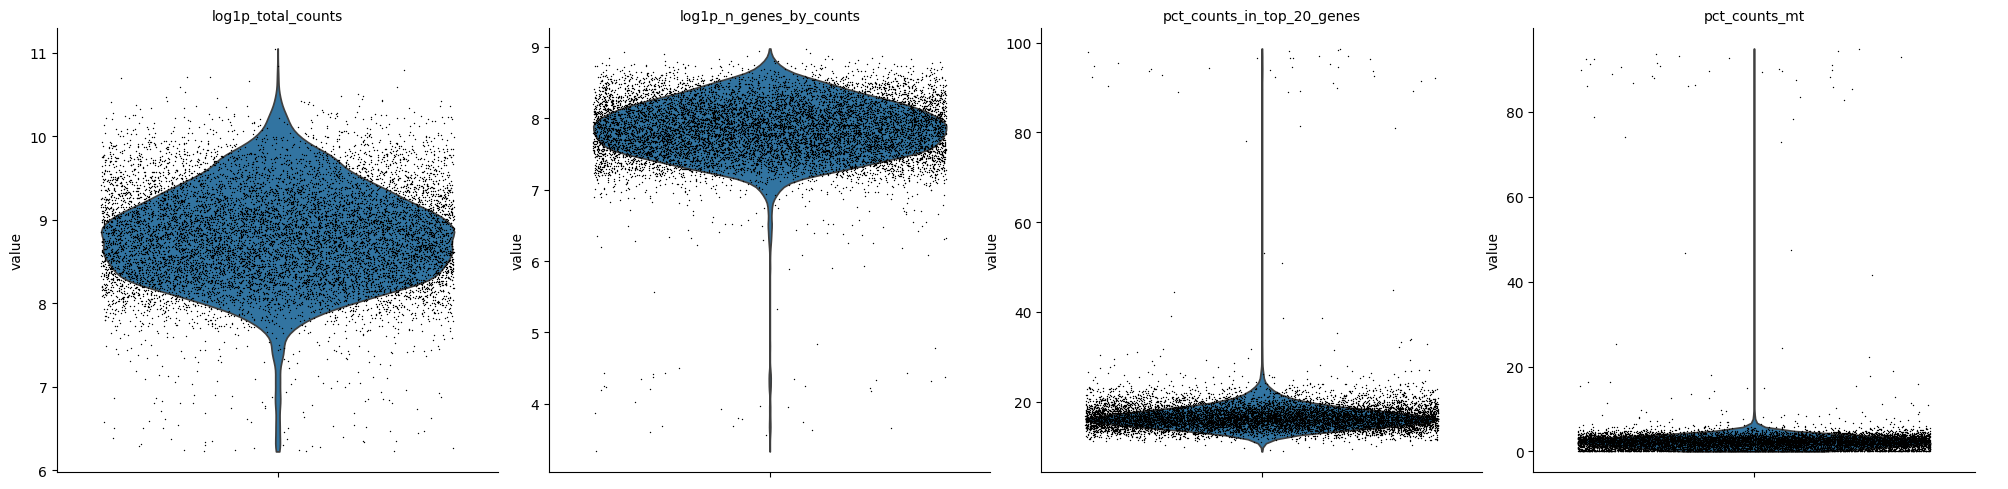

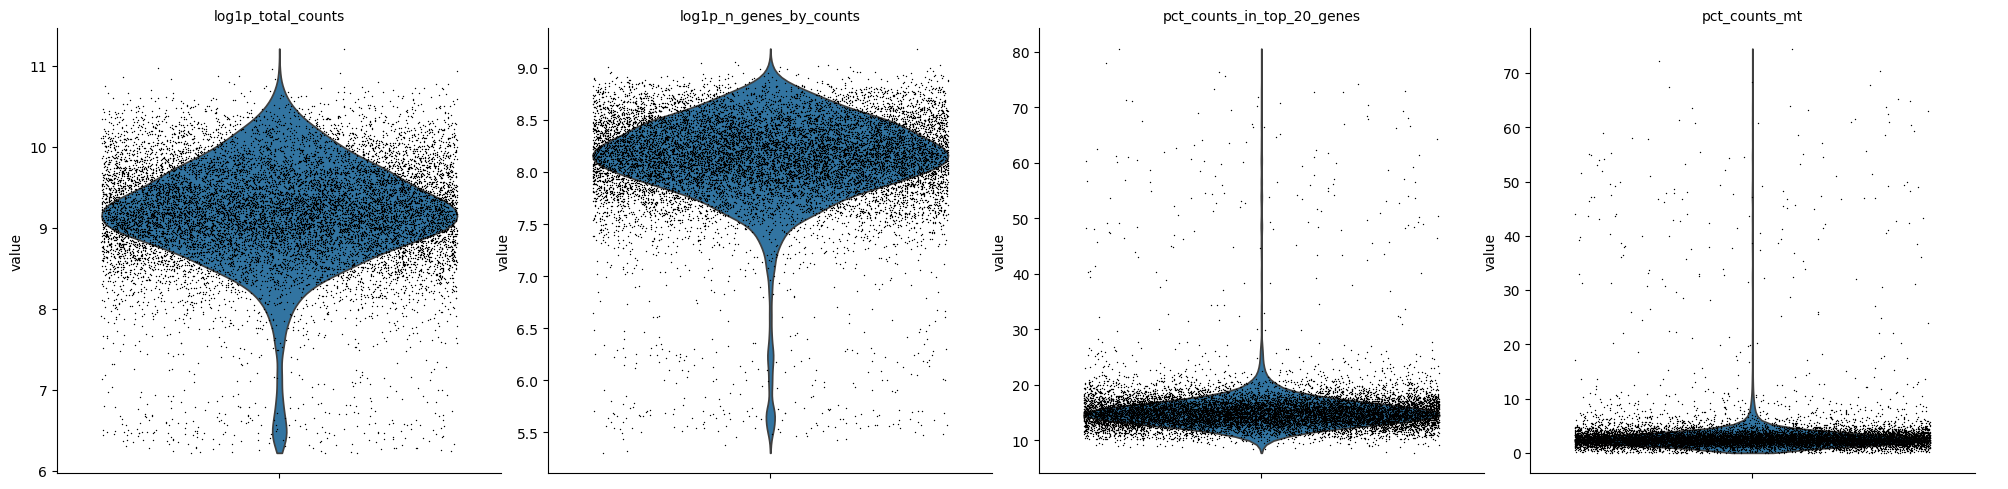

In [11]:
rna14_pre = day_14_data_combined.mod['rna']
rna28_pre = day_28_data_combined.mod['rna']

sc.pl.violin(rna14_pre, ['log1p_total_counts', 'log1p_n_genes_by_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)
sc.pl.violin(rna28_pre, ['log1p_total_counts', 'log1p_n_genes_by_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

Filter Out Outliers 

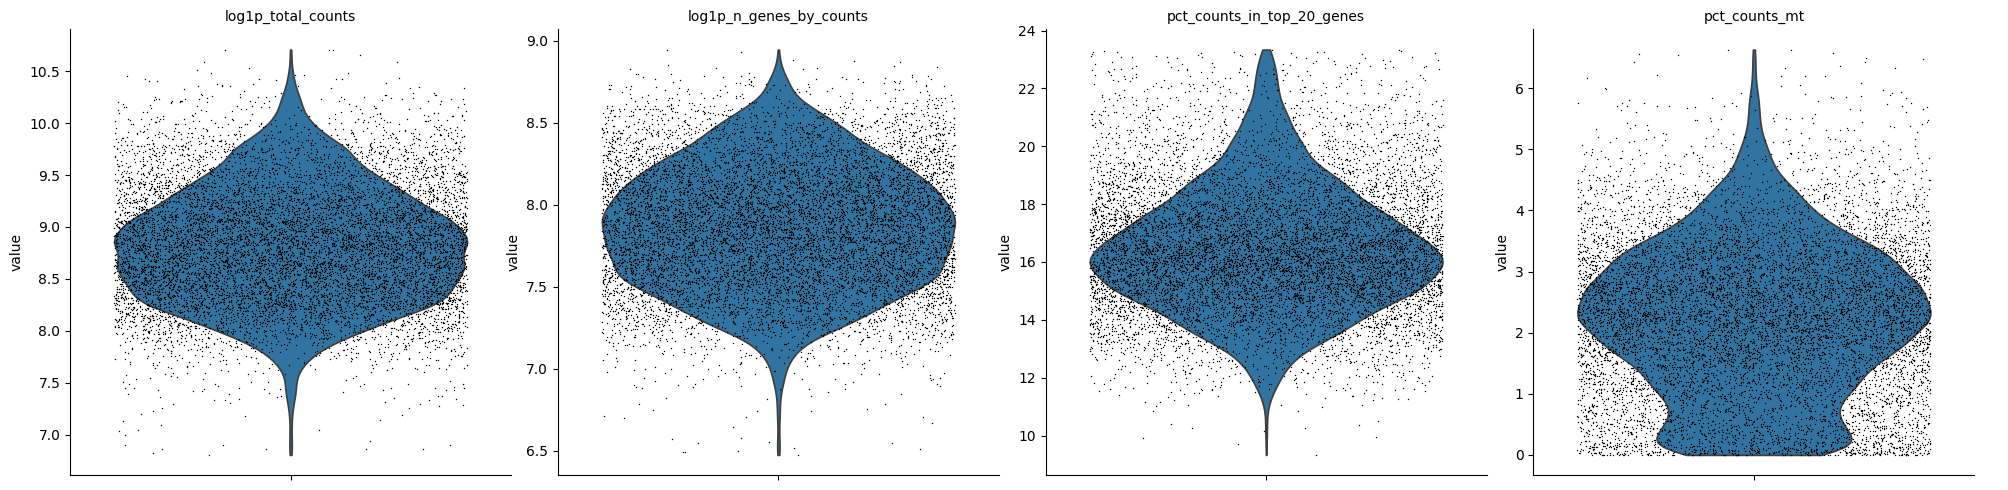

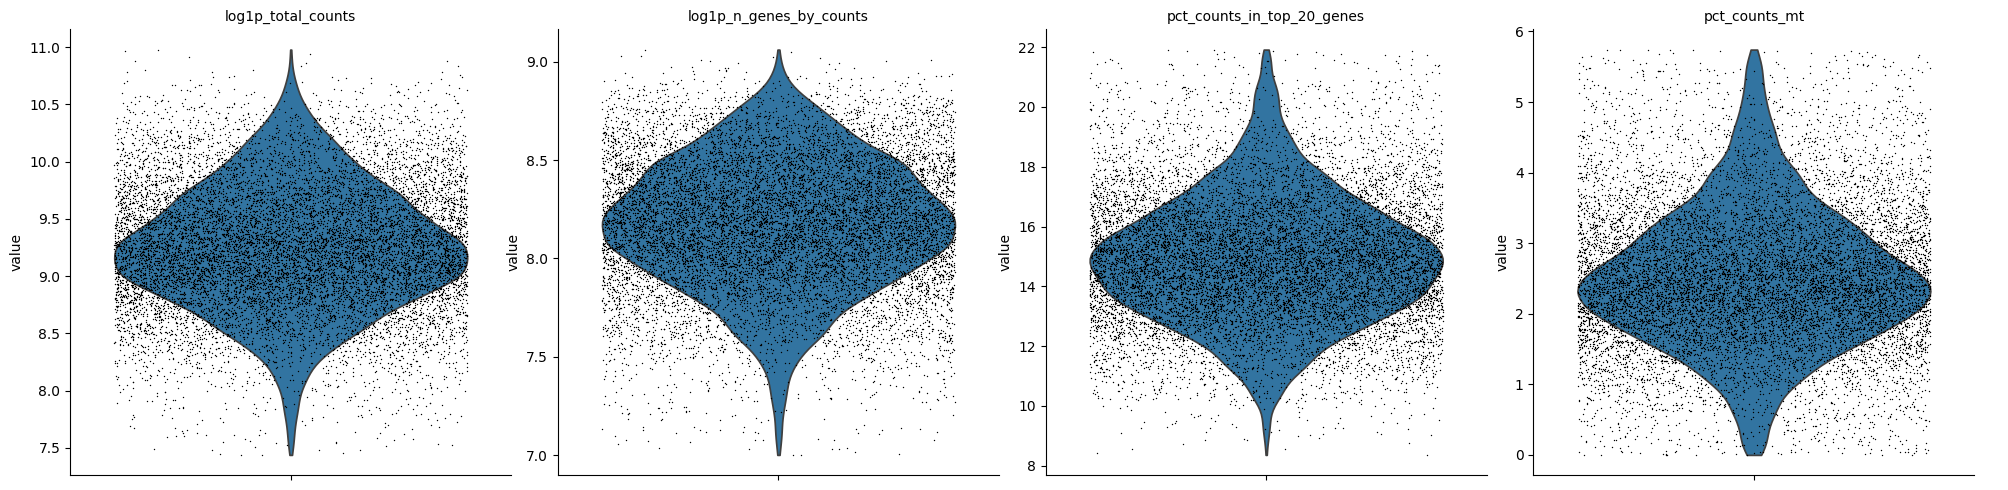

In [12]:
mu.pp.filter_obs(day_14_data_combined, 'outlier', lambda x: ~x)
mu.pp.filter_obs(day_28_data_combined, 'outlier', lambda x: ~x)

rna14_post = day_14_data_combined.mod['rna']
rna28_post = day_28_data_combined.mod['rna']

sc.pl.violin(rna14_post, ['log1p_total_counts', 'log1p_n_genes_by_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)
sc.pl.violin(rna28_post, ['log1p_total_counts', 'log1p_n_genes_by_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

Label doublets that are predicted by the package scrublet under scanpy

In [13]:
sc.pp.scrublet(day_14_data_combined.mod['rna'])
sc.pp.scrublet(day_28_data_combined.mod['rna'])

Then filter out the doublets predicted by scrublet

In [14]:
mu.pp.filter_obs(day_14_data_combined.mod['rna'], 'predicted_doublet', lambda x: ~x)
mu.pp.filter_obs(day_28_data_combined.mod['rna'], 'predicted_doublet', lambda x: ~x)

mu.pp.intersect_obs(day_14_data_combined)
mu.pp.intersect_obs(day_28_data_combined)

Normalize gene expression data.

In [15]:
day_14_data_combined.mod['rna'].layers["counts"] = day_14_data_combined.mod['rna'].X.copy()
day_28_data_combined.mod['rna'].layers["counts"] = day_28_data_combined.mod['rna'].X.copy()

sc.pp.normalize_total(day_14_data_combined.mod['rna'], target_sum = 10000)
sc.pp.normalize_total(day_28_data_combined.mod['rna'], target_sum = 10000)

sc.pp.log1p(day_14_data_combined.mod['rna'])
sc.pp.log1p(day_28_data_combined.mod['rna'])

day_14_data_combined.mod['rna'].layers["log_counts"] = day_14_data_combined.mod['rna'].X.copy()
day_28_data_combined.mod['rna'].layers["log_counts"] = day_28_data_combined.mod['rna'].X.copy()

Automatic cell type determination using celltypist. Ensure that the model you want is downloaded from celltypist at https://www.celltypist.org/models#video and then saved to the directory listed at celltypist.models.models_path. We are using Immune_All_Low for this determination.

In [16]:
day_14_copy = day_14_data_combined.mod['rna'].copy()
day_28_copy = day_28_data_combined.mod['rna'].copy()

immune_low_model = celltypist.models.Model.load('Immune_All_Low.pkl') 

day_14_predictions = celltypist.annotate(day_14_copy, model = immune_low_model, majority_voting = True)
day_28_predictions = celltypist.annotate(day_28_copy, model = immune_low_model, majority_voting = True)

day_14_data_combined.mod['rna'].obs['celltypist'] = day_14_predictions.predicted_labels['majority_voting']
day_28_data_combined.mod['rna'].obs['celltypist'] = day_28_predictions.predicted_labels['majority_voting']

day_14_data_combined.mod['rna'].obsm['celltypist_probabilities'] = day_14_predictions.probability_matrix
day_28_data_combined.mod['rna'].obsm['celltypist_probabilities'] = day_28_predictions.probability_matrix

copy_obs_to_global(day_14_data_combined, ['celltypist'])
copy_obs_to_global(day_28_data_combined, ['celltypist'])

🔬 Input data has 10550 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 6147 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 12837 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 6147 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


Create scaled counts layer as well

In [17]:
sc.pp.scale(day_14_data_combined.mod['rna'], max_value=10, zero_center=True)
sc.pp.scale(day_28_data_combined.mod['rna'], max_value=10, zero_center=True)

day_14_data_combined.mod['rna'].layers["scale_counts"] = day_14_data_combined.mod['rna'].X.copy()
day_28_data_combined.mod['rna'].layers["scale_counts"] = day_28_data_combined.mod['rna'].X.copy()

Filter out genes found in less than three cells. (We do this after celltypist to get more accurate annotations.)

In [18]:
def filter_var_and_layers(adata, var_key, condition):
    # Create a boolean mask and convert to NumPy array
    keep_genes = condition(adata.var[var_key]).to_numpy()

    # Subset .X and .var first
    adata._inplace_subset_var(keep_genes)

    # Now subset all layers to match the new .var
    for layer_name, layer_data in adata.layers.items():
        if layer_data.shape[1] != keep_genes.shape[0]:
            print(f"Skipping layer '{layer_name}' due to shape mismatch: {layer_data.shape}")
            continue
        adata.layers[layer_name] = layer_data[:, keep_genes]

filter_var_and_layers(day_14_data_combined.mod['rna'], 'n_cells_by_counts', lambda x: x > 3)
filter_var_and_layers(day_28_data_combined.mod['rna'], 'n_cells_by_counts', lambda x: x > 3)

day_14_data_combined.update_var()
day_28_data_combined.update_var()

Skipping layer 'counts' due to shape mismatch: (10550, 22345)
Skipping layer 'log_counts' due to shape mismatch: (10550, 22345)
Skipping layer 'scale_counts' due to shape mismatch: (10550, 22345)
Skipping layer 'counts' due to shape mismatch: (12837, 23639)
Skipping layer 'log_counts' due to shape mismatch: (12837, 23639)
Skipping layer 'scale_counts' due to shape mismatch: (12837, 23639)


Label highly variable genes.

In [18]:
sc.pp.highly_variable_genes(day_14_data_combined.mod['rna'])
sc.pp.highly_variable_genes(day_28_data_combined.mod['rna'])

Perform a Principle component analysis on both the protein and rna data

In [19]:
sc.tl.pca(day_14_data_combined.mod['rna'], svd_solver='arpack', random_state=123)
sc.tl.pca(day_28_data_combined.mod['rna'], svd_solver='arpack', random_state=123)

sc.tl.pca(day_14_data_combined.mod['prot'], svd_solver='arpack', random_state=123)
sc.tl.pca(day_28_data_combined.mod['prot'], svd_solver='arpack', random_state=123)

Calculate nearest neighbors and create the dimensionally reduced umap projection

In [20]:
sc.pp.neighbors(day_14_data_combined.mod['rna'], random_state=123)
sc.pp.neighbors(day_28_data_combined.mod['rna'], random_state=123)

sc.pp.neighbors(day_14_data_combined.mod['prot'], random_state=123)
sc.pp.neighbors(day_28_data_combined.mod['prot'], random_state=123)

mu.pp.neighbors(day_14_data_combined, random_state=123)
mu.pp.neighbors(day_28_data_combined, random_state=123)

In [21]:
sc.tl.umap(day_14_data_combined.mod['rna'], random_state=123)
sc.tl.umap(day_28_data_combined.mod['rna'], random_state=123)

sc.tl.umap(day_14_data_combined.mod['prot'], random_state=123)
sc.tl.umap(day_28_data_combined.mod['prot'], random_state=123)

mu.tl.umap(day_14_data_combined, random_state=123)
mu.tl.umap(day_28_data_combined, random_state=123)

Calculate leiden clustering in order to begin to determine cell types in your data based on group gene expression

In [22]:
for res in [0.05, 0.5, 2.0]:
    sc.tl.leiden(
        day_14_data_combined.mod['rna'], 
        key_added=f"leiden_res_{res:4.2f}", 
        resolution=res, 
        flavor="igraph",
        random_state=123
    )
for res in [0.05, 0.5, 2.0]:
    sc.tl.leiden(
        day_28_data_combined.mod['rna'], 
        key_added=f"leiden_res_{res:4.2f}", 
        resolution=res, 
        flavor="igraph",
        random_state=0
    )

sc.tl.leiden(day_14_data_combined.mod['prot'], random_state=123)
sc.tl.leiden(day_28_data_combined.mod['prot'], random_state=123)

mu.tl.leiden(day_14_data_combined, random_state=123)
mu.tl.leiden(day_28_data_combined, random_state=123)

Add antibody data to obs of the rna modality in muon object to be able to visualize antibody capture within scanpy sc.pl.umap() function specifically utilizing the RNA based umap.

In [23]:
for antibody in day_14_data_combined.mod['prot'].var.index:
    day_14_data_combined.mod['rna'].obs[antibody] = day_14_data_combined.mod['prot'][:, antibody].X.toarray().flatten()
    
for antibody in day_28_data_combined.mod['prot'].var.index:
    day_28_data_combined.mod['rna'].obs[antibody] = day_28_data_combined.mod['prot'][:, antibody].X.toarray().flatten()

Scoring based on highly expressed genes in single cell data of various ILC and NK lineages

In [24]:
#Cell type scoring based on gene markers
sc.tl.score_genes(day_14_data_combined.mod['rna'], ["MKI67", "PCNA", "CCNB1", "ANLN", "STMN1"], score_name='Prolif_Score', )
sc.tl.score_genes(day_28_data_combined.mod['rna'], ["MKI67", "PCNA", "CCNB1", "ANLN", "STMN1"], score_name='Prolif_Score', )

sc.tl.score_genes(day_14_data_combined.mod['rna'], ['TRBC1','TRDC','IL7R','IL4I1', 'RORC', 'AHR'], score_name='ILCP_Score', )
sc.tl.score_genes(day_28_data_combined.mod['rna'], ['TRBC1','TRDC','IL7R','IL4I1', 'RORC', 'AHR'], score_name='ILCP_Score', )

sc.tl.score_genes(day_14_data_combined.mod['rna'], ['KLRB1', 'HPGDS', 'IFITM1', 'DUSP1', 'CD69', 'FXYD5', 'PTGDR2', 'IL2RA', 'IL13'], score_name='ILC2_Score', )
sc.tl.score_genes(day_28_data_combined.mod['rna'], ['KLRB1', 'HPGDS', 'IFITM1', 'DUSP1', 'CD69', 'FXYD5', 'PTGDR2', 'IL2RA', 'IL13'], score_name='ILC2_Score', )

sc.tl.score_genes(day_14_data_combined.mod['rna'], ['IL12RB1', 'RORC', 'NCR2', 'AHR', 'AQP3', 'IL1R1', 'TMIGD2', 'TRBC1', 'IL23R'], score_name='ILC3_Score', )
sc.tl.score_genes(day_28_data_combined.mod['rna'], ['IL12RB1', 'RORC', 'NCR2', 'AHR', 'AQP3', 'IL1R1', 'TMIGD2', 'TRBC1', 'IL23R'], score_name='ILC3_Score', )

sc.tl.score_genes(day_14_data_combined.mod['rna'], ['GNLY', 'NKG7', 'EOMES', 'KLRD1', 'GZMB', 'CTSW', 'PRF1', 'CST7'], score_name='NK_Score', )
sc.tl.score_genes(day_28_data_combined.mod['rna'], ['GNLY', 'NKG7', 'EOMES', 'KLRD1', 'GZMB', 'CTSW', 'PRF1', 'CST7'], score_name='NK_Score', )

score_columns = ['Prolif_Score', 'ILCP_Score', 'ILC2_Score', 'ILC3_Score', 'NK_Score']
copy_obs_to_global(day_14_data_combined, score_columns)
copy_obs_to_global(day_28_data_combined, score_columns)

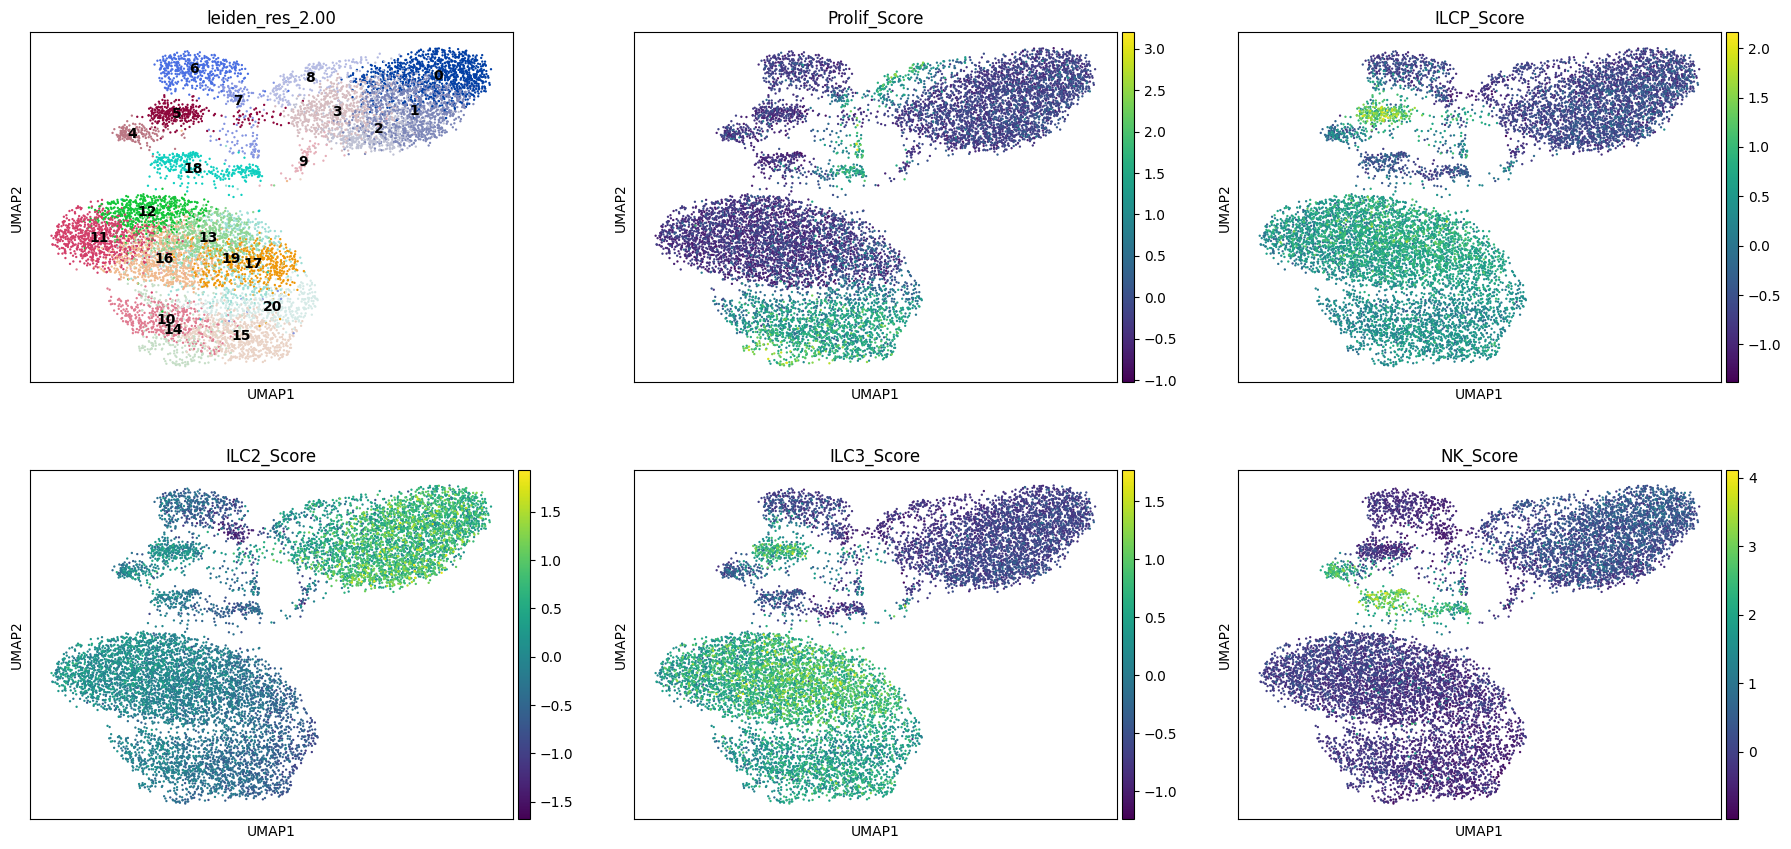

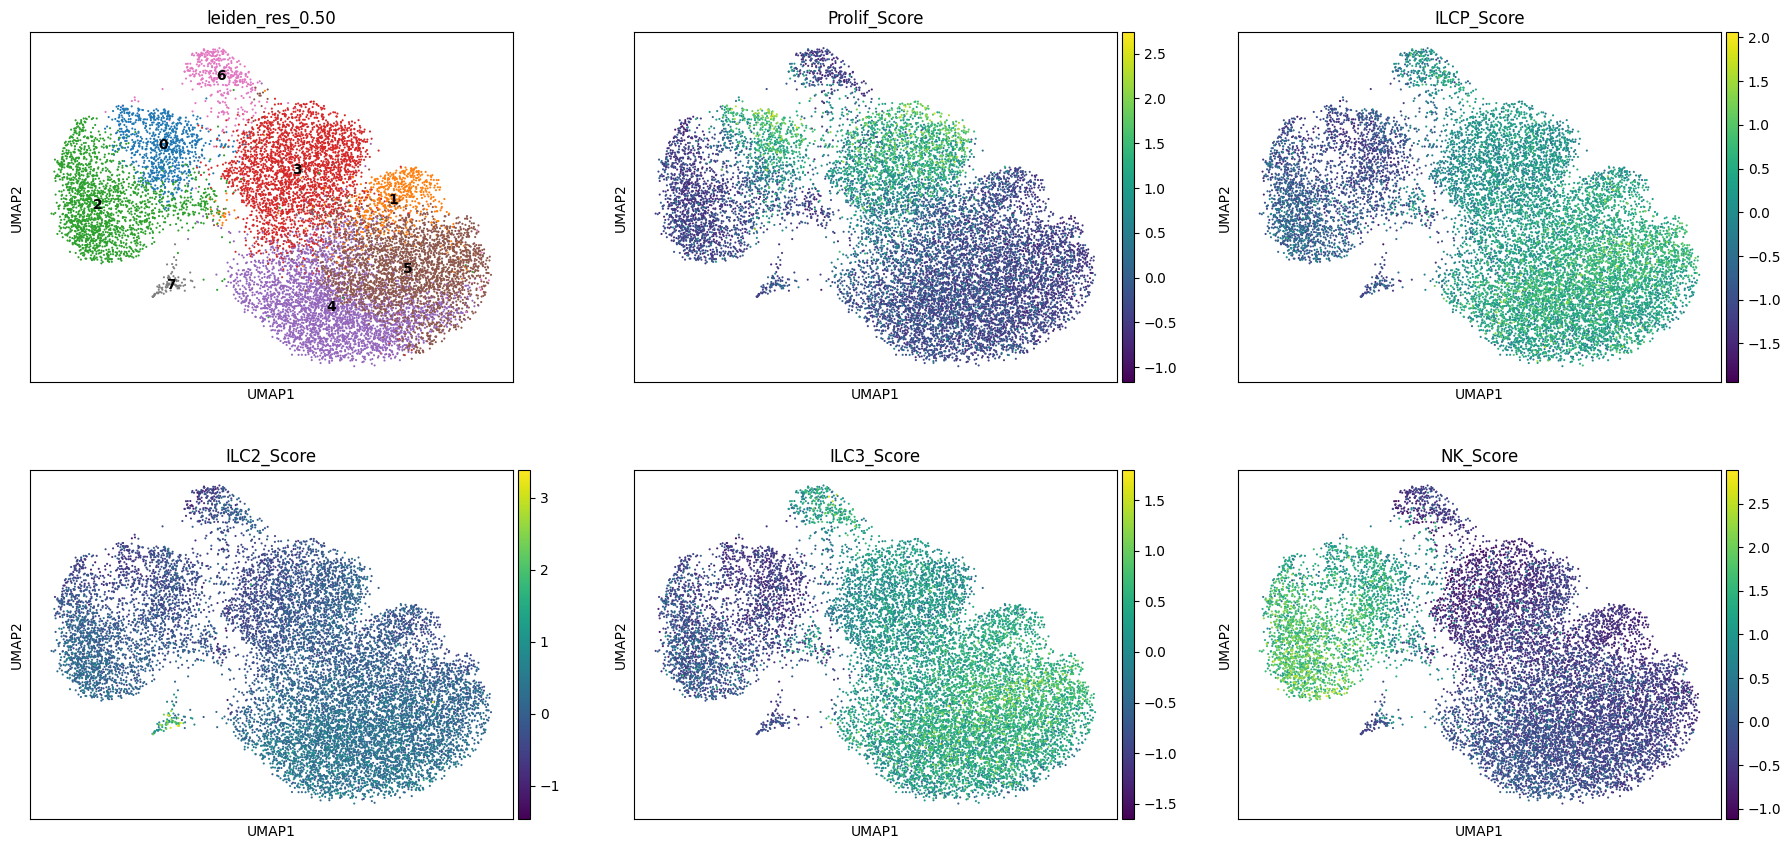

In [25]:
sc.pl.umap(day_14_data_combined.mod['rna'], color=['leiden_res_2.00', 'Prolif_Score', 'ILCP_Score', 'ILC2_Score', 'ILC3_Score', 'NK_Score'], ncols=3, legend_loc='on data')
sc.pl.umap(day_28_data_combined.mod['rna'], color=['leiden_res_0.50', 'Prolif_Score', 'ILCP_Score', 'ILC2_Score', 'ILC3_Score', 'NK_Score'], ncols=3, legend_loc='on data')

In [26]:
#Day 14 cell types
day_14_data_combined.mod['rna'].obs["celltype"] = day_14_data_combined.mod['rna'].obs["leiden_res_2.00"].map(
    {
        "0": "ILC2",
        "1": "NK",
        "2": "ILC2",
        "3": "ILC2",
        "4": "Early Precursors",
        "5": "Early Precursors",
        "6": "ILC2",
        "7": "ILC2",
        "8": "Stage3",
        "9": "pILC2",
        "10": "pNK",
        "11": "NK",
        "12": "ILC3",
        "13": "ILC3",
        "14": "ILC3",
        "15": "ILC3",
        "16": "pILC3",
        "17": "pILC3",
        "18": "ILC3",
        "19": "pILC3",
        "20": "pILC3"
    }
)

#Day 28 cell types
day_28_data_combined.mod['rna'].obs["celltype"] = day_28_data_combined.mod['rna'].obs["leiden_res_0.50"].map(
    {
        "0": "pNK",
        "1": "ILC3",
        "2": "ILC3",
        "3": "NK",
        "4": "ILC3",
        "5": "pILC3",
        "6": "ILC3",
        "7": "ILC2"
    }
)

day_14_data_combined['rna'].strings_to_categoricals()
day_28_data_combined['rna'].strings_to_categoricals()

... storing 'celltype' as categorical
... storing 'celltype' as categorical


In [27]:
condition_palette = { "15-C": "red", "15-D": "blue"}

day_14_data_combined['rna'].uns['condition_colors'] = [
    condition_palette[ct] for ct in day_14_data_combined['rna'].obs['condition'].cat.categories
]

day_28_data_combined['rna'].uns['condition_colors'] = [
    condition_palette[ct] for ct in day_28_data_combined['rna'].obs['condition'].cat.categories
]

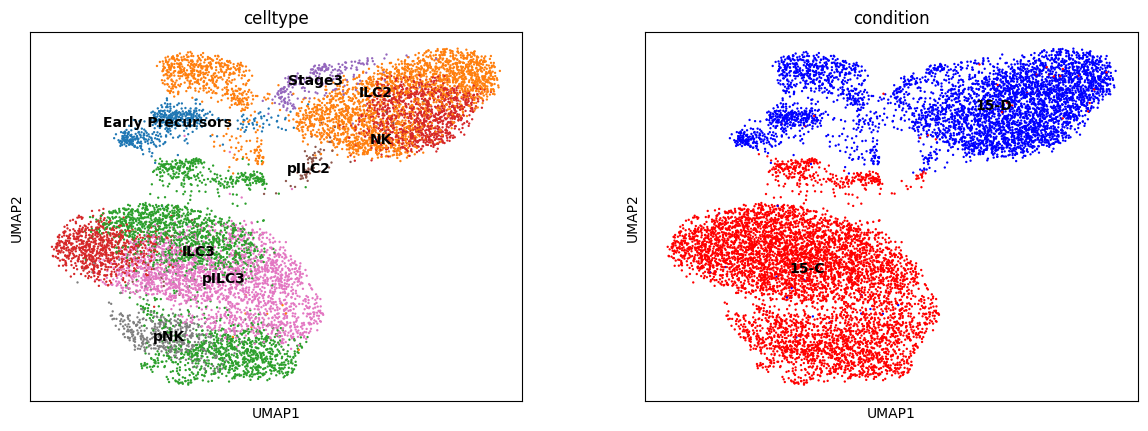

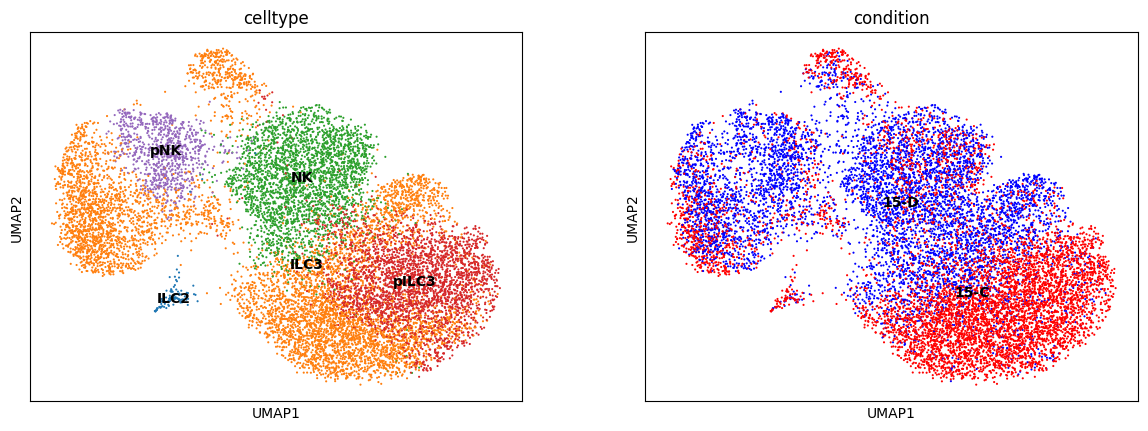

In [28]:
sc.pl.umap(day_14_data_combined['rna'], color=['celltype', 'condition'], legend_loc='on data')
sc.pl.umap(day_28_data_combined['rna'], color=['celltype', 'condition'], legend_loc='on data')

In [29]:
#Create a celltype_condition .obs for future analyses
day_14_data_combined['rna'].obs['cell_condition'] = day_14_data_combined['rna'].obs['celltype'].astype(str) + "_" + day_14_data_combined['rna'].obs['condition'].astype(str)
day_28_data_combined['rna'].obs['cell_condition'] = day_28_data_combined['rna'].obs['celltype'].astype(str) + "_" + day_28_data_combined['rna'].obs['condition'].astype(str)

copy_obs_to_global(day_14_data_combined, cols=['cell_condition', 'celltype'])
copy_obs_to_global(day_28_data_combined, cols=['cell_condition', 'celltype'])

Save mudata files prior to subsetting looking for NK cells specifically

In [30]:
day_14_data_combined.write_h5mu('D14_CITESeq_ALL.h5mu', compression = 'lzf')
day_28_data_combined.write_h5mu('D28_CITESeq_ALL.h5mu', compression = 'lzf')

... storing 'cell_condition' as categorical
... storing 'cell_condition' as categorical
... storing 'cell_condition' as categorical
... storing 'cell_condition' as categorical


## Session Info

In [31]:
import session_info
session_info.show(excludes=['distributed'])